### 数据描述（**北方华创**）[`002371`]
Stkcd [证券代码] - 以上交所、深交所公布的证券代码为准\
Trddt [交易日期] - 以YYYY-MM-DD表示\
Opnprc [日开盘价] - A股以人民币元计，上海B以美元计，深圳B以港币计\
Hiprc [日最高价] - A股以人民币元计，上海B以美元计，深圳B以港币计\
Loprc [日最低价] - A股以人民币元计，上海B以美元计，深圳B以港币计\
Clsprc [日收盘价] - A股以人民币元计，上海B以美元计，深圳B以港币计\
Dnshrtrd [日个股交易股数] - 0=没有交易量\
Dnvaltrd [日个股交易金额] - A股以人民币元计，上海B以美元计，深圳B以港币计，0=没有交易量

##### 从上海证券交易所和深圳证券交易所自选1家上市公司，下载2018年6月1日-2023年5月31日的日度交易行情信息：开盘价、最低价、最高价、收盘价、成交量和成交金额，进行下列数据分析实验：：
(1)画出每年正收益/负收益交易日天数的时间序列图。（10分）\
(2)将正收益/负收益的股票分别用1/0进行标签，给数据增加标签列。（10分）\
(3)对数据进行预处理，检查数据是否存在缺失值、无穷大值，这些值的存在将会影响预测结果，因此考虑填充和替换，将缺失值和无穷大值用0代替。（10分）\
(4)画出股票收益的直方图，判断股票收益是否服从正态分布。（10分）\
(5)基于8:2的训练集/测试集切分，使用日度行情信息及其滞后值信息，分别用K近邻、决策树、朴素贝叶斯、人工神经网络对下一个交易日股票价格运动方向进行预测，说明超参数选择，用测试集展示预测效果，将正收益定义为正类，计算召回率、精度、准确性，分析投资组合构建上应该如何使用这些算法评价指标。（40分）\
(6)基于K近邻、决策树、朴素贝叶斯、人工神经网络构建集成分类器，用硬投票对按时间顺序切分的训练集/测试集进行类别预测，并与随机森林预测效果对比。（20分）

In [1]:
# 导入所需要的包
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy import stats
from scipy.stats import norm

In [2]:
# 显示中文
font_path = '/workspaces/AllThings/大数据/大作业/SimHei.ttf'
font_prop = matplotlib.font_manager.FontProperties(fname=font_path)

In [3]:
data = pd.read_csv('./TRD_Dalyr.csv', encoding='utf-8')
data.head()

,Stkcd,Trddt,Opnprc,Hiprc,Loprc,Clsprc,Dnshrtrd,Dnvaltrd
0,2371,2018-06-01,43.30,44.00,40.83,41.38,14332779,6.056345e+08
1,2371,2018-06-04,41.18,42.96,40.43,41.55,14042904,5.864487e+08
2,2371,2018-06-05,41.00,44.49,41.00,44.00,14541660,6.238628e+08
3,2371,2018-06-06,43.53,44.66,43.38,43.95,9685803,4.259917e+08
4,2371,2018-06-07,44.30,44.44,42.80,43.44,7363878,3.214949e+08


In [4]:
renames = {
    'Stkcd': 'code',
    'Trddt': 'date',
    'Opnprc': 'open',
    'Hiprc': 'high',
    'Loprc': 'low',
    'Clsprc': 'close',
    'Dnshrtrd': 'volume',
    'Dsmvosd': 'amount'
}
data.rename(columns=renames, inplace=True)

In [5]:
data.index = pd.to_datetime(data['date'])
data.drop(['code', 'date'], axis=1, inplace=True)
data.head()

,open,high,low,close,volume,Dnvaltrd
date,,,,,,
2018-06-01,43.30,44.00,40.83,41.38,14332779,6.056345e+08
2018-06-04,41.18,42.96,40.43,41.55,14042904,5.864487e+08
2018-06-05,41.00,44.49,41.00,44.00,14541660,6.238628e+08
2018-06-06,43.53,44.66,43.38,43.95,9685803,4.259917e+08
2018-06-07,44.30,44.44,42.80,43.44,7363878,3.214949e+08


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1214 entries, 2018-06-01 to 2023-05-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      1214 non-null   float64
 1   high      1214 non-null   float64
 2   low       1214 non-null   float64
 3   close     1214 non-null   float64
 4   volume    1214 non-null   int64  
 5   Dnvaltrd  1214 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 66.4 KB


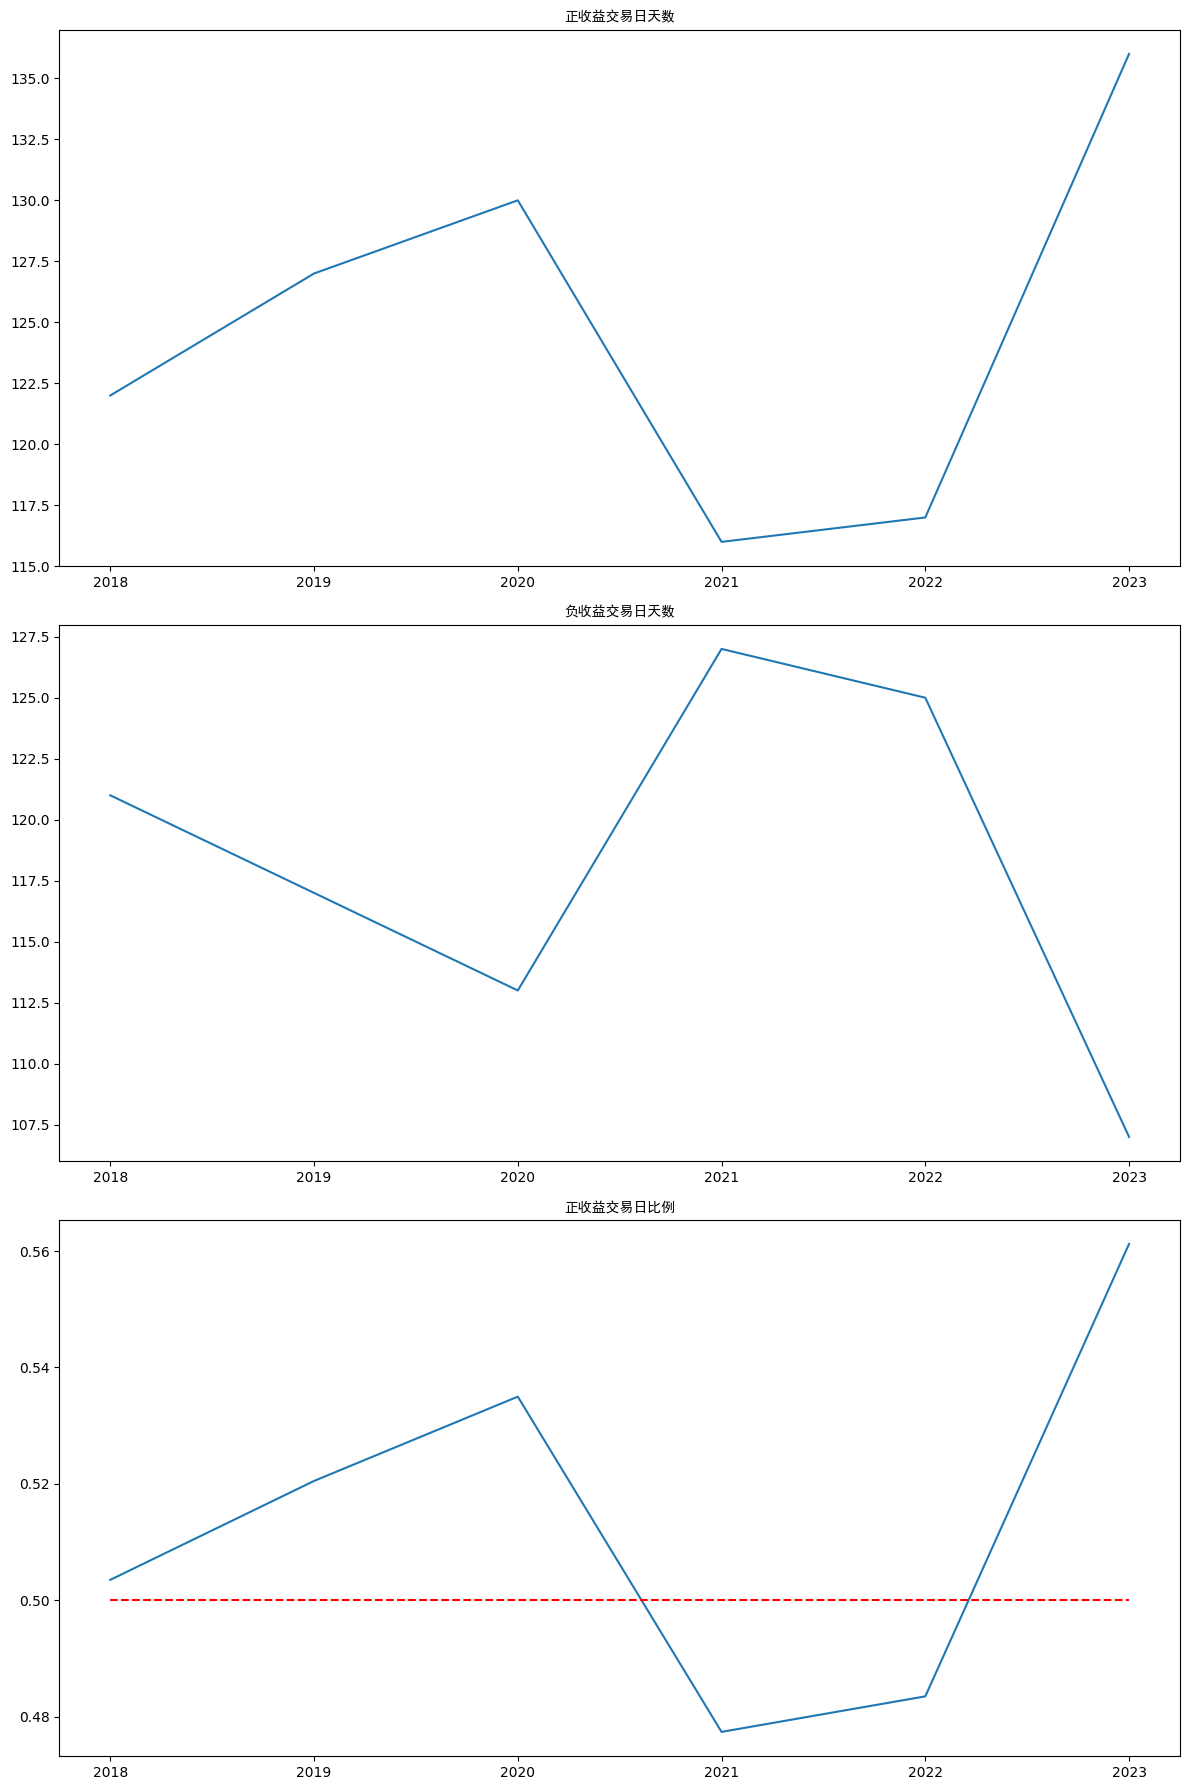

In [7]:
# (1)画出每年正收益/负收益交易日天数的时间序列图。（10分）
data['ret'] = data['close'] / data['close'].shift(1) - 1
res_pos = data.groupby(data.index.year)['ret'].apply(lambda x: sum(x > 0))
res_neg = data.groupby(data.index.year)['ret'].apply(lambda x: sum(x <= 0))
pos_ratio = res_pos / (res_pos + res_neg)
lacks = (243 - (res_pos + res_neg))
res_pos.iloc[[0,-1]] = (res_pos.iloc[[0,-1]] + lacks.iloc[[0,-1]] * pos_ratio.iloc[[0,-1]]).astype(int)
res_neg.iloc[[0,-1]] = 243 - res_pos.iloc[[0,-1]]

plt.figure(figsize=(12,18))
ax1 = plt.subplot(311)
ax1.plot(res_pos)
ax1.set_title('正收益交易日天数', fontproperties=font_prop)
ax2 = plt.subplot(312)
ax2.plot(res_neg)
ax2.set_title('负收益交易日天数', fontproperties=font_prop)
ax3 = plt.subplot(313)
ax3.plot(pos_ratio)
ax3.set_title('正收益交易日比例', fontproperties=font_prop)
ax3.plot([min(pos_ratio.index),max(pos_ratio.index)], [0.5, 0.5], 'r--')
plt.tight_layout()
plt.show()

In [8]:
# (2)将正收益/负收益的股票分别用1/0进行标签，给数据增加标签列。（10分）
data['label'] = np.where(data['ret'] > 0, 1, 0)
data.head()

,open,high,low,close,volume,Dnvaltrd,ret,label
date,,,,,,,,
2018-06-01,43.30,44.00,40.83,41.38,14332779,6.056345e+08,NaN,0
2018-06-04,41.18,42.96,40.43,41.55,14042904,5.864487e+08,0.004108,1
2018-06-05,41.00,44.49,41.00,44.00,14541660,6.238628e+08,0.058965,1
2018-06-06,43.53,44.66,43.38,43.95,9685803,4.259917e+08,-0.001136,0
2018-06-07,44.30,44.44,42.80,43.44,7363878,3.214949e+08,-0.011604,0


In [9]:
# (3)对数据进行预处理，检查数据是否存在缺失值、无穷大值，这些值的存在将会影响预测结果，因此考虑填充和替换，将缺失值和无穷大值用0代替。（10分）
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1214 entries, 2018-06-01 to 2023-05-31
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      1214 non-null   float64
 1   high      1214 non-null   float64
 2   low       1214 non-null   float64
 3   close     1214 non-null   float64
 4   volume    1214 non-null   int64  
 5   Dnvaltrd  1214 non-null   float64
 6   ret       1213 non-null   float64
 7   label     1214 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 85.4 KB


In [10]:
data.describe()

,open,high,low,close,volume,Dnvaltrd,ret,label
count,1214.000000,1214.000000,1214.000000,1214.000000,1.214000e+03,1.214000e+03,1213.000000,1214.000000
mean,181.724638,187.059555,177.290338,182.258138,9.358602e+06,1.571043e+09,0.002317,0.508237
std,105.750106,109.056215,102.905644,106.069288,4.540675e+06,1.051581e+09,0.036851,0.500138
min,37.470000,38.350000,35.690000,37.400000,2.726041e+06,1.377617e+08,-0.100016,0.000000
25%,68.932500,70.777500,67.210000,69.092500,6.078555e+06,7.673579e+08,-0.019459,0.000000
50%,173.535000,178.500000,169.760000,173.875000,8.234579e+06,1.357952e+09,0.000412,1.000000
75%,266.257500,273.500000,260.215000,266.697500,1.160303e+07,2.142552e+09,0.020353,1.000000
max,446.040000,452.780000,435.780000,451.900000,3.769396e+07,6.821416e+09,0.100111,1.000000


In [11]:
data.dropna(inplace=True)

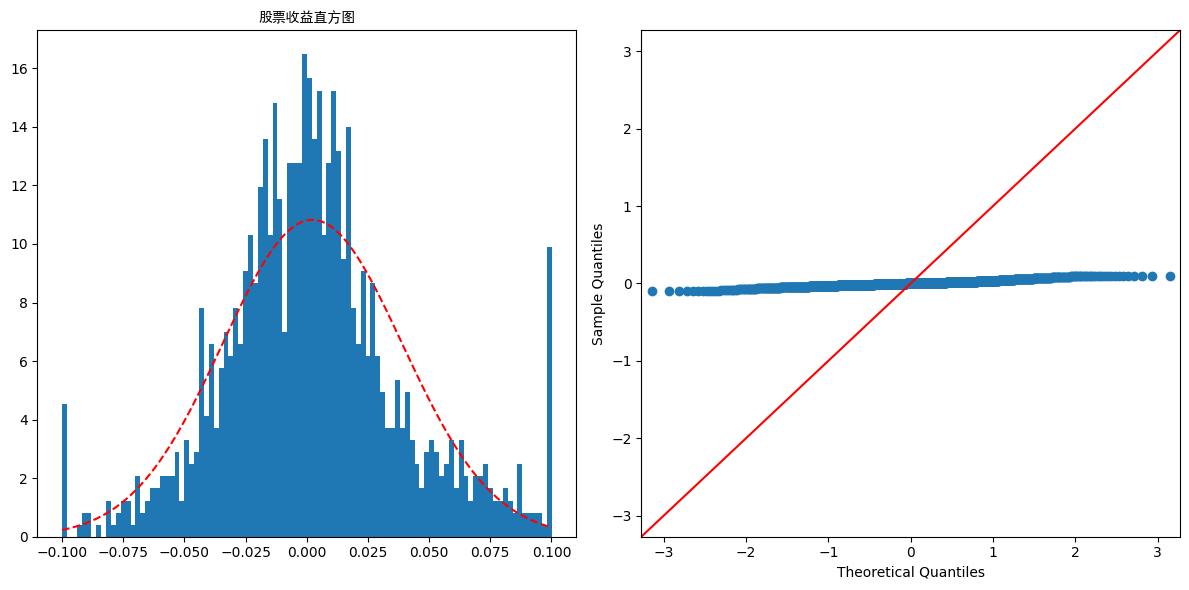

In [12]:
# (4)画出股票收益的直方图，判断股票收益是否服从正态分布。（10分）
plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
bins=100
n,bins,patches = ax1.hist(data['ret'], bins=bins, density=True)
mean = data['ret'].mean()
std = data['ret'].std()
y = norm.pdf(bins, mean, std)
ax1.plot(bins, y, 'r--')
ax1.set_title('股票收益直方图', fontproperties=font_prop)
# 绘制QQ图
import statsmodels.api as sm
ax2 = plt.subplot(122)
sm.qqplot(data['ret'], ax=ax2, line='45')
plt.tight_layout()
plt.show()

In [13]:
'''
(5)基于8:2的训练集/测试集切分，使用日度行情信息及其滞后值信息，
分别用K近邻、决策树、朴素贝叶斯、人工神经网络对下一个交易日股票价格运动方向进行预测，
说明超参数选择，用测试集展示预测效果，将正收益定义为正类，
计算召回率、精度、准确性，
分析投资组合构建上应该如何使用这些算法评价指标。（40分）
'''

'\n(5)基于8:2的训练集/测试集切分，使用日度行情信息及其滞后值信息，\n分别用K近邻、决策树、朴素贝叶斯、人工神经网络对下一个交易日股票价格运动方向进行预测，\n说明超参数选择，用测试集展示预测效果，将正收益定义为正类，\n计算召回率、精度、准确性，\n分析投资组合构建上应该如何使用这些算法评价指标。（40分）\n'

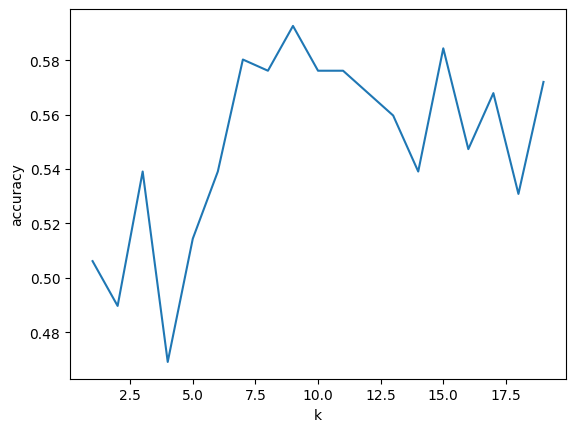

In [14]:
# 8:2的训练集/测试集切分
train_data = data.iloc[:int(len(data)*0.8)].drop(['ret'], axis=1)
test_data = data.iloc[int(len(data)*0.8):].drop(['ret'], axis=1)

# K近邻
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 超参数选择
# 选择最优的k值
k_list = range(1, 20)
scores = []
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
    scores.append(knn.score(test_data.iloc[:,:-1], test_data.iloc[:,-1]))
plt.plot(k_list, scores)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

In [15]:
k = 9
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
y_pred = knn.predict(test_data.iloc[:,:-1])
print(classification_report(test_data.iloc[:,-1], y_pred))
print(confusion_matrix(test_data.iloc[:,-1], y_pred))

              precision    recall  f1-score   support

           0       0.59      0.41      0.48       113
           1       0.59      0.75      0.66       130

    accuracy                           0.59       243
   macro avg       0.59      0.58      0.57       243
weighted avg       0.59      0.59      0.58       243

[[46 67]
 [32 98]]


In [16]:
# 决策树
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# 超参数选择
# 选择最优的max_depth、min_samples_split、min_samples_leaf
param_grid = {'max_depth': range(1, 10), 'min_samples_split': range(2, 10), 'min_samples_leaf': range(1, 10)}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid.fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
print(grid.best_params_)

{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [17]:
# 用最优的超参数构建模型
dtc = DecisionTreeClassifier(max_depth=grid.best_params_['max_depth'], min_samples_split=grid.best_params_['min_samples_split'], min_samples_leaf=grid.best_params_['min_samples_leaf'])
dtc.fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
y_pred = dtc.predict(test_data.iloc[:,:-1])
print(classification_report(test_data.iloc[:,-1], y_pred))
print(confusion_matrix(test_data.iloc[:,-1], y_pred))

              precision    recall  f1-score   support

           0       0.52      0.66      0.58       113
           1       0.61      0.46      0.53       130

    accuracy                           0.56       243
   macro avg       0.56      0.56      0.55       243
weighted avg       0.57      0.56      0.55       243

[[75 38]
 [70 60]]


In [18]:
# 朴素贝叶斯
from sklearn.naive_bayes import GaussianNB
# 选择最优的var_smoothing、priors
param_grid = {'var_smoothing': np.logspace(0,-9, num=100), 'priors': [None, [0.5, 0.5]]}
grid = GridSearchCV(GaussianNB(), param_grid, cv=5)
grid.fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
print(grid.best_params_)

{'priors': None, 'var_smoothing': 1e-07}


In [19]:
# 用最优的超参数构建模型
gnb = GaussianNB(var_smoothing=grid.best_params_['var_smoothing'], priors=grid.best_params_['priors'])
gnb.fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
y_pred = gnb.predict(test_data.iloc[:,:-1])
print(classification_report(test_data.iloc[:,-1], y_pred))
print(confusion_matrix(test_data.iloc[:,-1], y_pred))

              precision    recall  f1-score   support

           0       0.52      0.63      0.57       113
           1       0.61      0.50      0.55       130

    accuracy                           0.56       243
   macro avg       0.56      0.56      0.56       243
weighted avg       0.57      0.56      0.56       243

[[71 42]
 [65 65]]


In [26]:
# 一个两层的人工神经网络
from torch import nn
import torch

# 搭建一个两层的人工神经网络
net = nn.Sequential(
    nn.Linear(6, 100),
    nn.ReLU(),
    nn.Linear(100, 2),
    nn.Softmax(dim=1)
)
# 运行
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = net(torch.tensor(train_data.iloc[:,:-1].values, dtype=torch.float))
    loss = loss_func(y_pred, torch.tensor(train_data.iloc[:,-1].values, dtype=torch.long))
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('epoch: {}, loss: {}'.format(epoch, loss.item()))

epoch: 0, loss: 0.811199963092804
epoch: 10, loss: 0.811199963092804
epoch: 20, loss: 0.811199963092804
epoch: 30, loss: 0.811199963092804
epoch: 40, loss: 0.811199963092804
epoch: 50, loss: 0.811199963092804
epoch: 60, loss: 0.811199963092804
epoch: 70, loss: 0.811199963092804
epoch: 80, loss: 0.811199963092804
epoch: 90, loss: 0.811199963092804


In [25]:
# 预测并评估
y_pred = net(torch.tensor(test_data.iloc[:,:-1].values, dtype=torch.float))
_, y_pred = torch.max(y_pred, 1)
print(classification_report(test_data.iloc[:,-1], y_pred))
print(confusion_matrix(test_data.iloc[:,-1], y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       113
           1       0.53      1.00      0.70       130

    accuracy                           0.53       243
   macro avg       0.27      0.50      0.35       243
weighted avg       0.29      0.53      0.37       243

[[  0 113]
 [  0 130]]


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
